In [1]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    recall_score,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split

sys.path.append("..")

from shift_detector import *
from shift_reductor import *
from shift_experiments import *
from shift_explainer import *
from shift_tester import *
from shift_utils import *
from shift_models import *
from shift_constants import *
from shift_plot_utils import *


2022-04-21 10:41:28.989590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0.4/lib/R/lib::/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-04-21 10:41:28.989634: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-21 10:41:33.111783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 10:41:33.112593: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0

<IPython.core.display.Javascript object>

## Parameters ##

In [1]:
SHIFTS = ["pre-covid", "covid", "summer", "winter", "seasonal"]
OUTCOMES = ["length_of_stay_in_er", "mortality_in_hospital"]
HOSPITALS = ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW"]
MODELS = ["lr", "rf", "xgb","gp","mlp"]
NA_CUTOFF = 0.6
PATH = "/mnt/nfs/project/delirium/drift_exp/"
DATASET = "gemini"
SAMPLES = [10, 20, 50, 100, 200, 500, 1000, 2000]
RANDOM_RUNS = 5
SIGN_LEVEL = 0.05
CALC_ACC = True
DR_TECHNIQUES = ["NoRed", "SRP", "PCA", "BBSDs_FFNN"]  # "Isomap", "kPCA"]
MD_TESTS = ["MMD", "LK", "LSDD"]

## Model Fitting ##

In [12]:
# Run model fitting
if os.path.exists(PATH + "/shift_auc.pkl"):
    with open(PATH + "/shift_auc.pkl", "rb") as f:
        shift_auc = pickle.load(f)
else:
    shift_auc = np.ones(
        (len(SHIFTS), len(OUTCOMES), len(HOSPITALS), len(MODELS), 2)
    ) * (-1)

if os.path.exists(PATH + "/shift_pr.pkl"):
    with open(PATH + "/shift_pr.pkl", "rb") as f:
        shift_pr = pickle.load(f)
else:
    shift_pr = np.ones((len(SHIFTS), len(OUTCOMES), len(HOSPITALS), len(MODELS), 2)) * (
        -1
    )

<IPython.core.display.Javascript object>

In [6]:
for si, SHIFT in enumerate(SHIFTS):
    for oi, OUTCOME in enumerate(OUTCOMES):
        for hi, HOSPITAL in enumerate(HOSPITALS):
            for mi, MODEL in enumerate(MODELS):
                if np.any(shift_auc[si, oi, hi, mi, :] == -1)  or (SHIFT in ["summer", "winter", "seasonal"]):
                    print("{} | {} | {} | {}".format(SHIFT, OUTCOME, HOSPITAL, MODEL))
                    (
                        (X_train, y_train),
                        (X_val, y_val),
                        (X_test, y_test),
                        feats,
                        orig_dims,
                    ) = import_dataset_hospital(
                        SHIFT, OUTCOME, [HOSPITAL], NA_CUTOFF, shuffle=True
                    )

                    model_path = (
                        PATH + "_".join([SHIFT, OUTCOME, HOSPITAL, MODEL]) + ".pkl"
                    )
                    if os.path.exists(model_path):
                        optimised_model = pickle.load(open(model_path, "rb"))
                    else:
                        optimised_model = run_model(
                            MODEL, X_train, y_train, X_val, y_val
                        )
                        pickle.dump(
                            optimised_model,
                            open(
                                model_path,
                                "wb",
                            ),
                        )

                    # calc metrics for validation set
                    y_val_pred_prob = optimised_model.predict_proba(X_val)[:, 1]
                    val_fpr, val_tpr, val_thresholds = roc_curve(
                        y_val, y_val_pred_prob, pos_label=1
                    )

                    val_roc_auc = auc(val_fpr, val_tpr)

                    val_avg_pr = average_precision_score(y_val, y_val_pred_prob)
                    # val_recall = recall_score(y_val, y_val_pred_prob, average='weighted')

                    # calc metrics for test set
                    y_test_pred_prob = optimised_model.predict_proba(X_test)[:, 1]
                    test_fpr, test_tpr, test_thresholds = roc_curve(
                        y_test, y_test_pred_prob, pos_label=1
                    )
                    test_roc_auc = auc(test_fpr, test_tpr)
                    test_avg_pr = average_precision_score(y_test, y_test_pred_prob)
                    # test_recall = recall_score(y_test, y_test_pred_prob, average='weighted')

                    shift_auc[si, oi, hi, mi, :] = [val_roc_auc, test_roc_auc]
                    shift_pr[si, oi, hi, mi, :] = [val_avg_pr, test_avg_pr]


summer | length_of_stay_in_er | SMH | lr


2022-04-20 14:08:40,708 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:08:40,714 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:08:40,726 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 14:09:27,367 INFO cyclops.utils.profile - Finished executing function process in 46.659002 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the 

Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.01
summer | length_of_stay_in_er | SMH | rf


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2022-04-20 14:09:27,720 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:09:27,726 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:09:27,735 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 14:10:12,638 INFO cyclops.utils.profile - Finished executing function process in 44.917812 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 100


2022-04-20 14:10:15,536 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:10:15,542 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:10:15,552 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


summer | length_of_stay_in_er | SMH | xgb


2022-04-20 14:11:02,133 INFO cyclops.utils.profile - Finished executing function process in 46.596487 s


Best eta: 0.005
Best g: 2
Best n: 9


2022-04-20 14:12:55,304 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:12:55,312 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:12:55,325 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


summer | length_of_stay_in_er | MSH | lr


2022-04-20 14:13:42,004 INFO cyclops.utils.profile - Finished executing function process in 46.700308 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2022-04-20 14:13:43,104 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:13:43,111 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:13:43,121 INFO cyclops.processors.admin - # admin features:

summer | length_of_stay_in_er | MSH | rf


2022-04-20 14:14:29,771 INFO cyclops.utils.profile - Finished executing function process in 46.666866 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 14:14:31,861 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:14:31,868 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:14:31,880 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


summer | length_of_stay_in_er | MSH | xgb


2022-04-20 14:15:18,787 INFO cyclops.utils.profile - Finished executing function process in 46.925954 s
2022-04-20 14:17:13,772 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:17:13,785 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953


Best eta: 0.2
Best g: 0.5
Best n: 11
summer | length_of_stay_in_er | THPC | lr


2022-04-20 14:17:13,797 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 14:17:58,465 INFO cyclops.utils.profile - Finished executing function process in 44.692407 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.0001
summer | length_of_stay_in_er | THPC | rf


2022-04-20 14:18:46,028 INFO cyclops.utils.profile - Finished executing function process in 47.046213 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 14:18:48,650 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:18:48,657 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:18:48,667 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


summer | length_of_stay_in_er | THPC | xgb


2022-04-20 14:19:35,948 INFO cyclops.utils.profile - Finished executing function process in 47.297573 s
2022-04-20 14:21:58,458 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:21:58,468 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:21:58,479 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best eta: 0.2
Best g: 5
Best n: 3
summer | length_of_stay_in_er | THPM | lr


2022-04-20 14:22:42,827 INFO cyclops.utils.profile - Finished executing function process in 44.368934 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2022-04-20 14:22:43,266 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:22:43,272 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:22:43,283 INFO cyclops.processors.admin - # admin features:

Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 1e-07
summer | length_of_stay_in_er | THPM | rf


2022-04-20 14:23:28,036 INFO cyclops.utils.profile - Finished executing function process in 44.769950 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 14:23:31,440 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:23:31,446 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:23:31,457 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


summer | length_of_stay_in_er | THPM | xgb


2022-04-20 14:24:18,543 INFO cyclops.utils.profile - Finished executing function process in 47.102956 s


Best eta: 0.05
Best g: 0.5
Best n: 9
summer | length_of_stay_in_er | UHNTG | lr


2022-04-20 14:26:50,621 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:26:50,629 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:26:50,645 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 14:27:36,983 INFO cyclops.utils.profile - Finished executing function process in 46.362498 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05
Fitting model with C: 1e-06


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2022-04-20 14:27:37,431 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:27:37,437 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:27:37,447 INFO cyclops.processors.admin - # admin features:

Fitting model with C: 1e-07
Best C: 0.1
summer | length_of_stay_in_er | UHNTG | rf


2022-04-20 14:28:24,307 INFO cyclops.utils.profile - Finished executing function process in 46.876127 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500


2022-04-20 14:28:26,170 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:28:26,177 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:28:26,187 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best n: 5
summer | length_of_stay_in_er | UHNTG | xgb


2022-04-20 14:29:11,864 INFO cyclops.utils.profile - Finished executing function process in 45.694420 s


Best eta: 0.3
Best g: 5
Best n: 7
summer | length_of_stay_in_er | UHNTW | lr


2022-04-20 14:31:15,062 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:31:15,082 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:31:15,095 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 14:32:01,280 INFO cyclops.utils.profile - Finished executing function process in 46.217518 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.0001
summer | length_of_stay_in_er | UHNTW | rf


2022-04-20 14:32:48,395 INFO cyclops.utils.profile - Finished executing function process in 46.638168 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500


2022-04-20 14:32:50,121 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:32:50,128 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:32:50,139 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best n: 50
summer | length_of_stay_in_er | UHNTW | xgb


2022-04-20 14:33:37,212 INFO cyclops.utils.profile - Finished executing function process in 47.090674 s
2022-04-20 14:35:29,295 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:35:29,303 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:35:29,313 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best eta: 0.01
Best g: 0.5
Best n: 5
summer | mortality_in_hospital | SMH | lr


2022-04-20 14:36:13,529 INFO cyclops.utils.profile - Finished executing function process in 44.234085 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2022-04-20 14:36:13,908 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:36:13,913 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:36:13,923 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best C: 0.1
summer | mortality_in_hospital | SMH | rf


2022-04-20 14:37:00,455 INFO cyclops.utils.profile - Finished executing function process in 46.547072 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 14:37:02,255 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:37:02,261 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:37:02,271 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


summer | mortality_in_hospital | SMH | xgb


2022-04-20 14:37:49,328 INFO cyclops.utils.profile - Finished executing function process in 47.072920 s
2022-04-20 14:39:31,596 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:39:31,607 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:39:31,624 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best eta: 0.3
Best g: 1
Best n: 3
summer | mortality_in_hospital | MSH | lr


2022-04-20 14:40:15,683 INFO cyclops.utils.profile - Finished executing function process in 44.086659 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 1e-07
summer | mortality_in_hospital | MSH | rf


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2022-04-20 14:40:16,043 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:40:16,048 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:40:16,064 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 14:41:02,380 INFO cyclops.utils.profile - Finished executing function process in 46.336864 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 50


2022-04-20 14:41:06,126 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:41:06,133 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:41:06,144 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


summer | mortality_in_hospital | MSH | xgb


2022-04-20 14:41:52,261 INFO cyclops.utils.profile - Finished executing function process in 46.134921 s


Best eta: 0.3
Best g: 1
Best n: 9
summer | mortality_in_hospital | THPC | lr


2022-04-20 14:43:37,430 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:43:37,437 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:43:37,453 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 14:44:23,848 INFO cyclops.utils.profile - Finished executing function process in 46.416670 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 1e-05
summer | mortality_in_hospital | THPC | rf


2022-04-20 14:45:11,341 INFO cyclops.utils.profile - Finished executing function process in 46.906439 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 14:45:14,819 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:45:14,826 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:45:14,836 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


summer | mortality_in_hospital | THPC | xgb


2022-04-20 14:46:00,924 INFO cyclops.utils.profile - Finished executing function process in 46.104104 s
2022-04-20 14:48:29,109 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:48:29,119 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:48:29,130 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best eta: 0.3
Best g: 0.5
Best n: 3
summer | mortality_in_hospital | THPM | lr


2022-04-20 14:49:16,781 INFO cyclops.utils.profile - Finished executing function process in 47.673826 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.001
summer | mortality_in_hospital | THPM | rf


2022-04-20 14:50:03,507 INFO cyclops.utils.profile - Finished executing function process in 46.246053 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 14:50:06,533 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:50:06,540 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:50:06,550 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


summer | mortality_in_hospital | THPM | xgb


2022-04-20 14:50:53,357 INFO cyclops.utils.profile - Finished executing function process in 46.822492 s


Best eta: 0.1
Best g: 5
Best n: 7
summer | mortality_in_hospital | UHNTG | lr


2022-04-20 14:53:20,675 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:53:20,686 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:53:20,707 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 14:54:04,933 INFO cyclops.utils.profile - Finished executing function process in 44.258372 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1
summer | mortality_in_hospital | UHNTG | rf


2022-04-20 14:54:49,829 INFO cyclops.utils.profile - Finished executing function process in 44.393778 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500
summer | mortality_in_hospital | UHNTG | xgb


2022-04-20 14:54:52,336 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:54:52,342 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:54:52,356 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 14:55:36,719 INFO cyclops.utils.profile - Finished executing function process in 44.381918 s


Best eta: 0.3
Best g: 1
Best n: 3
summer | mortality_in_hospital | UHNTW | lr


2022-04-20 14:57:38,755 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:57:38,765 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:57:38,780 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 14:58:26,019 INFO cyclops.utils.profile - Finished executing function process in 47.261547 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1
summer | mortality_in_hospital | UHNTW | rf


2022-04-20 14:58:26,886 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:58:26,893 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:58:26,905 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 14:59:13,856 INFO cyclops.utils.profile - Finished executing function process in 46.969347 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 14:59:16,125 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 14:59:16,131 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 14:59:16,144 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


summer | mortality_in_hospital | UHNTW | xgb


2022-04-20 15:00:00,606 INFO cyclops.utils.profile - Finished executing function process in 44.480655 s


Best eta: 0.01
Best g: 1
Best n: 7
winter | length_of_stay_in_er | SMH | lr


2022-04-20 15:01:54,095 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:01:54,110 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:01:54,135 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 15:02:40,942 INFO cyclops.utils.profile - Finished executing function process in 46.845084 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1
winter | length_of_stay_in_er | SMH | rf


2022-04-20 15:02:41,884 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:02:41,891 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:02:41,911 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 15:03:27,075 INFO cyclops.utils.profile - Finished executing function process in 45.190206 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500


2022-04-20 15:03:28,910 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:03:28,918 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:03:28,927 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best n: 50
winter | length_of_stay_in_er | SMH | xgb


2022-04-20 15:04:16,325 INFO cyclops.utils.profile - Finished executing function process in 47.414408 s


Best eta: 0.05
Best g: 5
Best n: 3
winter | length_of_stay_in_er | MSH | lr


2022-04-20 15:06:12,230 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:06:12,243 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:06:12,263 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 15:06:56,707 INFO cyclops.utils.profile - Finished executing function process in 44.475107 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.0001
winter | length_of_stay_in_er | MSH | rf


2022-04-20 15:06:57,587 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:06:57,592 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:06:57,614 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 15:07:42,417 INFO cyclops.utils.profile - Finished executing function process in 44.830426 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 100


2022-04-20 15:07:44,404 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:07:44,411 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:07:44,421 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


winter | length_of_stay_in_er | MSH | xgb


2022-04-20 15:08:31,477 INFO cyclops.utils.profile - Finished executing function process in 47.070961 s


Best eta: 0.3
Best g: 1.5
Best n: 11
winter | length_of_stay_in_er | THPC | lr


2022-04-20 15:10:23,863 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:10:23,870 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:10:23,882 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 15:11:07,589 INFO cyclops.utils.profile - Finished executing function process in 43.725768 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 1e-07
winter | length_of_stay_in_er | THPC | rf


2022-04-20 15:11:52,236 INFO cyclops.utils.profile - Finished executing function process in 44.045050 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500


2022-04-20 15:11:54,151 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:11:54,157 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:11:54,167 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best n: 50
winter | length_of_stay_in_er | THPC | xgb


2022-04-20 15:12:38,442 INFO cyclops.utils.profile - Finished executing function process in 44.290253 s


Best eta: 0.05
Best g: 5
Best n: 7
winter | length_of_stay_in_er | THPM | lr


2022-04-20 15:14:39,906 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:14:39,916 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:14:39,934 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 15:15:26,816 INFO cyclops.utils.profile - Finished executing function process in 46.911411 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1
winter | length_of_stay_in_er | THPM | rf


2022-04-20 15:16:13,953 INFO cyclops.utils.profile - Finished executing function process in 46.650125 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 15:16:16,776 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:16:16,782 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:16:16,791 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


winter | length_of_stay_in_er | THPM | xgb


2022-04-20 15:17:00,942 INFO cyclops.utils.profile - Finished executing function process in 44.165478 s


Best eta: 0.01
Best g: 5
Best n: 11


2022-04-20 15:19:29,482 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:19:29,491 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:19:29,502 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


winter | length_of_stay_in_er | UHNTG | lr


2022-04-20 15:20:16,028 INFO cyclops.utils.profile - Finished executing function process in 46.544276 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1
winter | length_of_stay_in_er | UHNTG | rf


2022-04-20 15:21:02,303 INFO cyclops.utils.profile - Finished executing function process in 45.791100 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 100


2022-04-20 15:21:04,417 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:21:04,422 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:21:04,431 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


winter | length_of_stay_in_er | UHNTG | xgb


2022-04-20 15:21:48,220 INFO cyclops.utils.profile - Finished executing function process in 43.803560 s


Best eta: 0.3
Best g: 1.5
Best n: 9


2022-04-20 15:23:55,002 INFO cyclops.processors.base - Processing raw admin data...


winter | length_of_stay_in_er | UHNTW | lr


2022-04-20 15:23:55,009 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:23:55,026 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 15:24:41,602 INFO cyclops.utils.profile - Finished executing function process in 46.600105 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 1e-07


2022-04-20 15:24:57,511 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:24:57,524 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:24:57,533 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


winter | length_of_stay_in_er | UHNTW | rf


2022-04-20 15:25:44,338 INFO cyclops.utils.profile - Finished executing function process in 46.826532 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 100


2022-04-20 15:25:50,581 INFO cyclops.processors.base - Processing raw admin data...


winter | length_of_stay_in_er | UHNTW | xgb


2022-04-20 15:25:55,970 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:25:55,985 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 15:26:42,422 INFO cyclops.utils.profile - Finished executing function process in 51.840654 s


Best eta: 0.3
Best g: 0.5
Best n: 11
winter | mortality_in_hospital | SMH | lr


2022-04-20 15:28:40,625 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:28:40,633 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:28:40,649 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 15:29:24,913 INFO cyclops.utils.profile - Finished executing function process in 44.288162 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05
Fitting model with C: 1e-06


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-07
Best C: 0.001


2022-04-20 15:29:25,546 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:29:25,558 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:29:25,571 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


winter | mortality_in_hospital | SMH | rf


2022-04-20 15:30:11,058 INFO cyclops.utils.profile - Finished executing function process in 45.511996 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 15:30:13,269 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:30:13,276 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:30:13,286 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


winter | mortality_in_hospital | SMH | xgb


2022-04-20 15:30:59,397 INFO cyclops.utils.profile - Finished executing function process in 46.127487 s
2022-04-20 15:32:52,514 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:32:52,525 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:32:52,537 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best eta: 0.05
Best g: 0.5
Best n: 3
winter | mortality_in_hospital | MSH | lr


2022-04-20 15:33:36,315 INFO cyclops.utils.profile - Finished executing function process in 43.800897 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2022-04-20 15:33:36,733 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:33:36,738 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:33:36,753 INFO cyclops.processors.admin - # admin features:

Best C: 1e-06
winter | mortality_in_hospital | MSH | rf


2022-04-20 15:34:21,170 INFO cyclops.utils.profile - Finished executing function process in 44.435658 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 15:34:23,276 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:34:23,282 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:34:23,291 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


winter | mortality_in_hospital | MSH | xgb


2022-04-20 15:35:07,498 INFO cyclops.utils.profile - Finished executing function process in 44.221044 s


Best eta: 0.05
Best g: 1
Best n: 9
winter | mortality_in_hospital | THPC | lr


2022-04-20 15:37:00,548 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:37:00,558 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:37:00,575 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 15:37:47,001 INFO cyclops.utils.profile - Finished executing function process in 46.453214 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1
winter | mortality_in_hospital | THPC | rf


2022-04-20 15:38:31,025 INFO cyclops.utils.profile - Finished executing function process in 43.494038 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 15:38:33,607 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:38:33,614 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:38:33,624 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


winter | mortality_in_hospital | THPC | xgb


2022-04-20 15:39:20,455 INFO cyclops.utils.profile - Finished executing function process in 46.847793 s
2022-04-20 15:41:48,544 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:41:48,554 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:41:48,564 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best eta: 0.1
Best g: 2
Best n: 9
winter | mortality_in_hospital | THPM | lr


2022-04-20 15:42:34,835 INFO cyclops.utils.profile - Finished executing function process in 46.290601 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1
winter | mortality_in_hospital | THPM | rf


2022-04-20 15:43:22,341 INFO cyclops.utils.profile - Finished executing function process in 46.955351 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 15:43:25,138 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:43:25,144 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:43:25,153 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


winter | mortality_in_hospital | THPM | xgb


2022-04-20 15:44:09,736 INFO cyclops.utils.profile - Finished executing function process in 44.597502 s


Best eta: 0.05
Best g: 0.5
Best n: 7
winter | mortality_in_hospital | UHNTG | lr


2022-04-20 15:46:37,710 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:46:37,718 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:46:37,733 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 15:47:21,423 INFO cyclops.utils.profile - Finished executing function process in 43.712599 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.001
winter | mortality_in_hospital | UHNTG | rf


2022-04-20 15:48:06,149 INFO cyclops.utils.profile - Finished executing function process in 44.218933 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 100


2022-04-20 15:48:08,338 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:48:08,346 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:48:08,356 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


winter | mortality_in_hospital | UHNTG | xgb


2022-04-20 15:48:54,618 INFO cyclops.utils.profile - Finished executing function process in 46.279992 s
2022-04-20 15:50:58,958 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:50:58,966 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:50:58,977 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best eta: 0.2
Best g: 5
Best n: 11
winter | mortality_in_hospital | UHNTW | lr


2022-04-20 15:51:42,803 INFO cyclops.utils.profile - Finished executing function process in 43.844762 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001
Fitting model with C: 1e-05


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2022-04-20 15:51:43,197 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:51:43,203 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:51:43,213 INFO cyclops.processors.admin - # admin features:

Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.01
winter | mortality_in_hospital | UHNTW | rf


2022-04-20 15:52:27,479 INFO cyclops.utils.profile - Finished executing function process in 44.281570 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 15:52:29,773 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:52:29,780 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:52:29,789 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


winter | mortality_in_hospital | UHNTW | xgb


2022-04-20 15:53:14,058 INFO cyclops.utils.profile - Finished executing function process in 44.284869 s
2022-04-20 15:55:11,826 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:55:11,836 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:55:11,846 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best eta: 0.05
Best g: 5
Best n: 3
seasonal | length_of_stay_in_er | SMH | lr


2022-04-20 15:55:55,760 INFO cyclops.utils.profile - Finished executing function process in 43.934282 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1
seasonal | length_of_stay_in_er | SMH | rf


2022-04-20 15:56:42,618 INFO cyclops.utils.profile - Finished executing function process in 46.336131 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 15:56:45,933 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 15:56:45,940 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 15:56:45,954 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | length_of_stay_in_er | SMH | xgb


2022-04-20 15:57:32,607 INFO cyclops.utils.profile - Finished executing function process in 46.673664 s


Best eta: 0.3
Best g: 5
Best n: 5
seasonal | length_of_stay_in_er | MSH | lr


2022-04-20 16:00:24,909 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:00:24,917 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:00:24,930 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 16:01:11,255 INFO cyclops.utils.profile - Finished executing function process in 46.346168 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.0001
seasonal | length_of_stay_in_er | MSH | rf


2022-04-20 16:01:55,932 INFO cyclops.utils.profile - Finished executing function process in 44.138156 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 16:01:58,909 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:01:58,916 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:01:58,926 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | length_of_stay_in_er | MSH | xgb


2022-04-20 16:02:45,857 INFO cyclops.utils.profile - Finished executing function process in 46.947236 s
2022-04-20 16:05:30,410 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:05:30,420 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:05:30,433 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best eta: 0.05
Best g: 0.5
Best n: 7
seasonal | length_of_stay_in_er | THPC | lr


2022-04-20 16:06:16,865 INFO cyclops.utils.profile - Finished executing function process in 46.455363 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 0.0001
Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.0001
seasonal | length_of_stay_in_er | THPC | rf


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2022-04-20 16:06:17,537 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:06:17,543 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:06:17,553 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 16:07:03,815 INFO cyclops.utils.profile - Finished executing function process in 46.278206 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 50
seasonal | length_of_stay_in_er | THPC | xgb


2022-04-20 16:07:06,982 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:07:06,988 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:07:06,996 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 16:07:50,610 INFO cyclops.utils.profile - Finished executing function process in 43.627868 s


Best eta: 0.05
Best g: 2
Best n: 11
seasonal | length_of_stay_in_er | THPM | lr


2022-04-20 16:11:18,029 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:11:18,036 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:11:18,047 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 16:12:02,336 INFO cyclops.utils.profile - Finished executing function process in 44.306752 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 0.0001
Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2022-04-20 16:12:03,101 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:12:03,106 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:12:03,116 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | length_of_stay_in_er | THPM | rf


2022-04-20 16:12:47,608 INFO cyclops.utils.profile - Finished executing function process in 44.507795 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 100


2022-04-20 16:12:52,142 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:12:52,148 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:12:52,158 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | length_of_stay_in_er | THPM | xgb


2022-04-20 16:13:36,208 INFO cyclops.utils.profile - Finished executing function process in 44.064861 s


Best eta: 0.1
Best g: 5
Best n: 3
seasonal | length_of_stay_in_er | UHNTG | lr


2022-04-20 16:17:28,348 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:17:28,357 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:17:28,368 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 16:18:14,877 INFO cyclops.utils.profile - Finished executing function process in 46.528901 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1
seasonal | length_of_stay_in_er | UHNTG | rf


2022-04-20 16:19:01,801 INFO cyclops.utils.profile - Finished executing function process in 46.351412 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 100


2022-04-20 16:19:05,394 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:19:05,400 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:19:05,409 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | length_of_stay_in_er | UHNTG | xgb


2022-04-20 16:19:49,628 INFO cyclops.utils.profile - Finished executing function process in 44.233955 s
2022-04-20 16:22:56,193 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:22:56,204 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:22:56,215 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best eta: 0.2
Best g: 0.5
Best n: 9
seasonal | length_of_stay_in_er | UHNTW | lr


2022-04-20 16:23:40,084 INFO cyclops.utils.profile - Finished executing function process in 43.890631 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1
seasonal | length_of_stay_in_er | UHNTW | rf


2022-04-20 16:24:24,357 INFO cyclops.utils.profile - Finished executing function process in 43.735519 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 16:24:27,848 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:24:27,854 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:24:27,870 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | length_of_stay_in_er | UHNTW | xgb


2022-04-20 16:25:14,726 INFO cyclops.utils.profile - Finished executing function process in 46.878206 s


Best eta: 0.005
Best g: 0.5
Best n: 11
seasonal | mortality_in_hospital | SMH | lr


2022-04-20 16:28:09,591 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:28:09,600 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:28:09,617 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 16:28:55,536 INFO cyclops.utils.profile - Finished executing function process in 45.945423 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.001
seasonal | mortality_in_hospital | SMH | rf


2022-04-20 16:29:40,100 INFO cyclops.utils.profile - Finished executing function process in 43.937256 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 16:29:42,946 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:29:42,951 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:29:42,961 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | mortality_in_hospital | SMH | xgb


2022-04-20 16:30:29,723 INFO cyclops.utils.profile - Finished executing function process in 46.777482 s
2022-04-20 16:33:16,418 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:33:16,431 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:33:16,442 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best eta: 0.1
Best g: 5
Best n: 9
seasonal | mortality_in_hospital | MSH | lr


2022-04-20 16:34:02,300 INFO cyclops.utils.profile - Finished executing function process in 45.882003 s
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1
seasonal | mortality_in_hospital | MSH | rf


2022-04-20 16:34:46,619 INFO cyclops.utils.profile - Finished executing function process in 43.820302 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 16:34:49,349 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:34:49,355 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:34:49,368 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | mortality_in_hospital | MSH | xgb


2022-04-20 16:35:33,327 INFO cyclops.utils.profile - Finished executing function process in 43.978016 s


Best eta: 0.1
Best g: 5
Best n: 3
seasonal | mortality_in_hospital | THPC | lr


2022-04-20 16:38:18,157 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:38:18,163 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:38:18,176 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 16:39:01,915 INFO cyclops.utils.profile - Finished executing function process in 43.758276 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 0.0001
Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2022-04-20 16:39:02,687 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:39:02,692 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:39:02,700 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best C: 0.1
seasonal | mortality_in_hospital | THPC | rf


2022-04-20 16:39:46,537 INFO cyclops.utils.profile - Finished executing function process in 43.850140 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 16:39:50,917 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:39:50,923 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:39:50,936 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | mortality_in_hospital | THPC | xgb


2022-04-20 16:40:37,680 INFO cyclops.utils.profile - Finished executing function process in 46.763012 s


Best eta: 0.1
Best g: 5
Best n: 9
seasonal | mortality_in_hospital | THPM | lr


2022-04-20 16:44:41,260 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:44:41,270 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:44:41,286 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 16:45:25,291 INFO cyclops.utils.profile - Finished executing function process in 44.030870 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 0.0001
Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.01


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
2022-04-20 16:45:25,988 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:45:25,994 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:45:26,003 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | mortality_in_hospital | THPM | rf


2022-04-20 16:46:12,564 INFO cyclops.utils.profile - Finished executing function process in 46.576048 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 16:46:17,486 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:46:17,492 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:46:17,506 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | mortality_in_hospital | THPM | xgb


2022-04-20 16:47:03,869 INFO cyclops.utils.profile - Finished executing function process in 46.382876 s
2022-04-20 16:50:49,726 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:50:49,739 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:50:49,750 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


Best eta: 0.3
Best g: 5
Best n: 3
seasonal | mortality_in_hospital | UHNTG | lr


2022-04-20 16:51:33,865 INFO cyclops.utils.profile - Finished executing function process in 44.138166 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.01
seasonal | mortality_in_hospital | UHNTG | rf


2022-04-20 16:52:18,839 INFO cyclops.utils.profile - Finished executing function process in 44.436117 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 100


2022-04-20 16:52:21,993 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:52:21,999 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:52:22,015 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | mortality_in_hospital | UHNTG | xgb


2022-04-20 16:53:05,908 INFO cyclops.utils.profile - Finished executing function process in 43.913905 s


Best eta: 0.1
Best g: 5
Best n: 5
seasonal | mortality_in_hospital | UHNTW | lr


2022-04-20 16:56:06,973 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:56:06,985 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:56:07,003 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-20 16:56:52,915 INFO cyclops.utils.profile - Finished executing function process in 45.943198 s


Fitting model with C: 0.1
Fitting model with C: 0.01
Fitting model with C: 0.001
Fitting model with C: 0.0001


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Fitting model with C: 1e-05
Fitting model with C: 1e-06
Fitting model with C: 1e-07
Best C: 0.1
seasonal | mortality_in_hospital | UHNTW | rf


2022-04-20 16:57:37,240 INFO cyclops.utils.profile - Finished executing function process in 43.757082 s


Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


2022-04-20 16:57:40,555 INFO cyclops.processors.base - Processing raw admin data...
2022-04-20 16:57:40,562 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-20 16:57:40,603 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953


seasonal | mortality_in_hospital | UHNTW | xgb


2022-04-20 16:58:24,746 INFO cyclops.utils.profile - Finished executing function process in 44.191170 s


Best eta: 0.1
Best g: 5
Best n: 11


<IPython.core.display.Javascript object>

In [7]:
if not os.path.exists(PATH + "/shift_auc.pkl"):
    with open(PATH + "/shift_auc.pkl", "wb") as f:
        pickle.dump(shift_auc, f)
if not os.path.exists(PATH + "/shift_pr.pkl"):
    with open(PATH + "/shift_pr.pkl", "wb") as f:
        pickle.dump(shift_pr, f)

<IPython.core.display.Javascript object>

## ROC AUC ##

In [15]:
auc_file = PATH + "/driftexp_auc.csv"
if os.path.exists(auc_file):
    all_auc = pd.read_csv(auc_file, sep="\t", header=[0, 1, 2], index_col=[0, 1])
else:
    all_auc = np.rollaxis(shift_auc, 4, 1)
    cols = pd.MultiIndex.from_product(
        [
            OUTCOMES,
            HOSPITALS,
            MODELS,
        ]
    )
    index = pd.MultiIndex.from_product([SHIFTS, ["VAL_ROC_AUC", "TEST_ROC_AUC"]])
    all_auc = all_auc.reshape(
        len(SHIFTS) * 2, len(OUTCOMES) * len(HOSPITALS) * len(MODELS)
    )
    all_auc = pd.DataFrame(all_auc, columns=cols, index=index)
    all_auc.to_csv(auc_file, sep="\t")
all_auc.head(n=10)

length_of_stay_in_er                                \
                                        SMH                           MSH   
                                         lr        rf       xgb        lr   
pre-covid VAL_ROC_AUC              0.685077  0.679966  0.698393  0.566220   
          TEST_ROC_AUC             0.642507  0.607752  0.627380  0.609688   
covid     VAL_ROC_AUC              0.631242  0.683626  0.855658  0.627196   
          TEST_ROC_AUC             0.527422  0.537757  0.525798  0.608638   
summer    VAL_ROC_AUC              0.709691  0.573438  0.718881  0.484106   
          TEST_ROC_AUC             0.614141  0.640415  0.583768  0.596742   
winter    VAL_ROC_AUC              0.721528  0.679006  0.759598  0.610094   
          TEST_ROC_AUC             0.575490  0.560690  0.588586  0.588233   
seasonal  VAL_ROC_AUC              0.605823  0.671599  0.698691  0.612962   
          TEST_ROC_AUC             0.628347  0.635830  0.616060  0.511055   

                                                                          \
                                                THPC                       
                              rf       xgb        lr        rf       xgb   
pre-covid VAL_ROC_AUC   0.656885  0.613776  0.631915  0.605530  0.701081   
          TEST_ROC_AUC  0.613614  0.612724  0.646738  0.639663  0.712715   
covid     VAL_ROC_AUC   0.628763  0.667785  0.633527  0.630492  0.681453   
          TEST_ROC_AUC  0.630080  0.631802  0.600501  0.612604  0.621335   
summer    VAL_ROC_AUC   0.657390  0.656328  0.571716  0.624705  0.813322   
          TEST_ROC_AUC  0.538386  0.557886  0.537304  0.610319  0.663882   
winter    VAL_ROC_AUC   0.680569  0.682984  0.567846  0.584277  0.662912   
          TEST_ROC_AUC  0.646145  0.606705  0.515961  0.630460  0.737796   
seasonal  VAL_ROC_AUC   0.717015  0.701790  0.644771  0.653797  0.762517   
          TEST_ROC_AUC  0.553190  0.541383  0.521770  0.644131  0.652518   

                                  ... mortality_in_hospital            \
                            THPM  ...                  THPC      THPM   
                              lr  ...                   xgb        lr   
pre-covid VAL_ROC_AUC   0.622109  ...              0.804163  0.769393   
          TEST_ROC_AUC  0.634415  ...              0.826634  0.773520   
covid     VAL_ROC_AUC   0.642752  ...              0.838525  0.788514   
          TEST_ROC_AUC  0.577815  ...              0.825559  0.758934   
summer    VAL_ROC_AUC   0.548540  ...              0.841226  0.730047   
          TEST_ROC_AUC  0.554803  ...              0.756369  0.743208   
winter    VAL_ROC_AUC   0.698539  ...              0.845351  0.753762   
          TEST_ROC_AUC  0.646844  ...              0.767157  0.732821   
seasonal  VAL_ROC_AUC   0.692114  ...              0.812637  0.764571   
          TEST_ROC_AUC  0.606998  ...              0.779523  0.765733   

                                                                          \
                                               UHNTG                       
                              rf       xgb        lr        rf       xgb   
pre-covid VAL_ROC_AUC   0.782642  0.804211  0.754195  0.708317  0.781442   
          TEST_ROC_AUC  0.803547  0.807082  0.726976  0.764703  0.776332   
covid     VAL_ROC_AUC   0.814293  0.827120  0.716387  0.772647  0.793052   
          TEST_ROC_AUC  0.819457  0.805789  0.696609  0.760753  0.744392   
summer    VAL_ROC_AUC   0.752463  0.768693  0.694954  0.788208  0.832025   
          TEST_ROC_AUC  0.770202  0.774707  0.674151  0.709262  0.704820   
winter    VAL_ROC_AUC   0.724957  0.756307  0.635192  0.731446  0.852190   
          TEST_ROC_AUC  0.784026  0.759509  0.741359  0.738412  0.769978   
seasonal  VAL_ROC_AUC   0.787212  0.765824  0.753640  0.782721  0.787711   
          TEST_ROC_AUC  0.772455  0.787183  0.721615  0.747815  0.721990   

                                                      
                           UHNTW      

<IPython.core.display.Javascript object>

## Avg Precision ## 

In [10]:
pr_file = PATH + "/driftexp_pr.csv"
if os.path.exists(pr_file):
    pr = pd.read_csv(pr_file, sep="\t", header=[0, 1, 2], index_col=[0, 1])
else:
    pr = np.rollaxis(shift_pr, 4, 1)
    cols = pd.MultiIndex.from_product([OUTCOMES, HOSPITALS, MODELS])
    index = pd.MultiIndex.from_product([SHIFTS, ["VAL_AVG_PR", "TEST_AVG_PR"]])
    pr = pr.reshape(len(SHIFTS) * 2, len(OUTCOMES) * len(HOSPITALS) * len(MODELS))
    pr = pd.DataFrame(pr, columns=cols, index=index)
    pr.to_csv(pr_file, sep="\t")
pr.head(n=10)

length_of_stay_in_er                                \
                                       SMH                           MSH   
                                        lr        rf       xgb        lr   
pre-covid VAL_AVG_PR              0.963674  0.957496  0.965287  0.926774   
          TEST_AVG_PR             0.956293  0.947867  0.950945  0.944635   
covid     VAL_AVG_PR              0.952438  0.959760  0.983736  0.942762   
          TEST_AVG_PR             0.927761  0.928200  0.924837  0.888672   
summer    VAL_AVG_PR              0.969173  0.933612  0.962087  0.863009   
          TEST_AVG_PR             0.942457  0.948574  0.932642  0.936357   
winter    VAL_AVG_PR              0.979877  0.962251  0.976883  0.945810   
          TEST_AVG_PR             0.936335  0.937453  0.939887  0.946463   
seasonal  VAL_AVG_PR              0.938586  0.966905  0.967252  0.967191   
          TEST_AVG_PR             0.943202  0.941331  0.934854  0.896710   

                                                                         \
                                               THPC                       
                             rf       xgb        lr        rf       xgb   
pre-covid VAL_AVG_PR   0.951242  0.940339  0.982330  0.980631  0.984906   
          TEST_AVG_PR  0.940464  0.940862  0.983729  0.982424  0.988094   
covid     VAL_AVG_PR   0.942892  0.949709  0.983655  0.978965  0.986268   
          TEST_AVG_PR  0.884944  0.901402  0.964567  0.967740  0.971053   
summer    VAL_AVG_PR   0.906191  0.907414  0.973521  0.980335  0.992943   
          TEST_AVG_PR  0.922450  0.917540  0.976327  0.978225  0.980445   
winter    VAL_AVG_PR   0.956542  0.952512  0.980808  0.984828  0.987487   
          TEST_AVG_PR  0.963494  0.965041  0.981497  0.985908  0.991629   
seasonal  VAL_AVG_PR   0.981668  0.978245  0.990071  0.983908  0.994544   
          TEST_AVG_PR  0.905960  0.909699  0.972416  0.978704  0.979741   

                                 ... mortality_in_hospital            \
                           THPM  ...                  THPC      THPM   
                             lr  ...                   xgb        lr   
pre-covid VAL_AVG_PR   0.932441  ...              0.217650  0.265299   
          TEST_AVG_PR  0.929164  ...              0.237370  0.255550   
covid     VAL_AVG_PR   0.938714  ...              0.269774  0.273020   
          TEST_AVG_PR  0.845510  ...              0.296712  0.295666   
summer    VAL_AVG_PR   0.875732  ...              0.248100  0.168429   
          TEST_AVG_PR  0.871457  ...              0.196609  0.204482   
winter    VAL_AVG_PR   0.964484  ...              0.285717  0.266758   
          TEST_AVG_PR  0.947651  ...              0.211780  0.184521   
seasonal  VAL_AVG_PR   0.963572  ...              0.283362  0.194406   
          TEST_AVG_PR  0.892374  ...              0.206595  0.217188   

                                                                         \
                                              UHNTG                       
                             rf       xgb        lr        rf       xgb   
pre-covid VAL_AVG_PR   0.274416  0.290236  0.262854  0.135012  0.282909   
          TEST_AVG_PR  0.305829  0.318708  0.178841  0.200371  0.236748   
covid     VAL_AVG_PR   0.353413  0.365054  0.198689  0.227043  0.244693   
          TEST_AVG_PR  0.429879  0.392413  0.137305  0.187095  0.178531   
summer    VAL_AVG_PR   0.290750  0.260715  0.139840  0.228221  0.237840   
          TEST_AVG_PR  0.273205  0.250202  0.153771  0.145883  0.196804   
winter    VAL_AVG_PR   0.239860  0.233866  0.160526  0.166549  0.262022   
          TEST_AVG_PR  0.245788  0.230327  0.245367  0.234943  0.205297   
seasonal  VAL_AVG_PR   0.316601  0.292216  0.182191  0.234296  0.268850   
          TEST_AVG_PR  0.257224  0.248178  0.143607  0.166247  0.180682   

                                                     
                          UHNTW                      
                             lr     

<IPython.core.display.Javascript object>

## Drift Detection ##

In [3]:
# Run shift experiments
if os.path.exists(PATH + "/mean_dr_md.pkl"):
    with open(PATH + "/mean_dr_md.pkl", "rb") as f:
        mean_dr_md = pickle.load(f)
else:
    mean_dr_md = np.ones(
        (len(SHIFTS), len(HOSPITALS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

if os.path.exists(PATH + "/std_dr_md.pkl"):
    with open(PATH + "/std_dr_md.pkl", "rb") as f:
        std_dr_md = pickle.load(f)
else:
    std_dr_md = np.ones(
        (len(SHIFTS), len(HOSPITALS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

for si, SHIFT in enumerate(SHIFTS):
    for hi, HOSPITAL in enumerate(HOSPITALS):
        for di, DR_TECHNIQUE in enumerate(DR_TECHNIQUES):
            for mi, MD_TEST in enumerate(MD_TESTS):
                if np.any(mean_dr_md[si, hi, di, mi, :] == -1):
                    print(
                        "{} | {} | {} | {}".format(
                            SHIFT, HOSPITAL, DR_TECHNIQUE, MD_TEST
                        )
                    )
                    try:
                        mean_p_vals, std_p_vals = run_shift_experiment(
                            SHIFT,
                            OUTCOME,
                            HOSPITAL,
                            PATH,
                            DR_TECHNIQUE,
                            MD_TEST,
                            SAMPLES,
                            DATASET,
                            SIGN_LEVEL,
                            NA_CUTOFF,
                            RANDOM_RUNS,
                            calc_acc=True,
                        )
                        mean_dr_md[si, hi, di, mi, :] = mean_p_vals
                        std_dr_md[si, hi, di, mi, :] = std_p_vals
                    except ValueError as e:
                        print("Value Error")
                        pass

<IPython.core.display.Javascript object>

In [4]:
means_file = PATH + "/driftexp_means.csv"
if os.path.exists(means_file):
    means = pd.read_csv(means_file, sep="\t", header=[0, 1], index_col=[0, 1, 2])
else:
    means = np.moveaxis(mean_dr_md, 4, 2)
    cols = pd.MultiIndex.from_product([DR_TECHNIQUES, MD_TESTS])
    index = pd.MultiIndex.from_product([SHIFTS, HOSPITALS, SAMPLES])
    means = means.reshape(
        len(SHIFTS) * len(HOSPITALS) * len(SAMPLES), len(DR_TECHNIQUES) * len(MD_TESTS)
    )
    means = pd.DataFrame(means, columns=cols, index=index)
    means.index.names = ["Dataset", "Hospital", "Samples"]
    means.to_csv(PATH + "/driftexp_means.csv", sep="\t")

stds_file = PATH + "/driftexp_stds.csv"
if os.path.exists(stds_file):
    means = pd.read_csv(stds_file, sep="\t", header=[0, 1], index_col=[0, 1, 2])
else:
    stds = np.moveaxis(std_dr_md, 4, 2)
    cols = pd.MultiIndex.from_product([DR_TECHNIQUES, MD_TESTS])
    index = pd.MultiIndex.from_product([SHIFTS, HOSPITALS, SAMPLES])
    stds = stds.reshape(
        len(SHIFTS) * len(HOSPITALS) * len(SAMPLES), len(DR_TECHNIQUES) * len(MD_TESTS)
    )
    stds = pd.DataFrame(stds, columns=cols, index=index)
    stds.to_csv(PATH + "/driftexp_stds.csv", sep="\t")

pd.set_option("display.max_rows", 500)
means.head(n=16)

NoRed                  SRP                  PCA  \
                              MMD     LK   LSDD    MMD     LK   LSDD    MMD   
Dataset   Hospital Samples                                                    
pre-covid SMH      10       0.374  0.456  0.154  0.488  0.418  0.316  0.388   
                   20       0.316  0.476  0.032  0.362  0.608  0.358  0.334   
                   50       0.264  0.426  0.070  0.578  0.402  0.428  0.300   
                   100      0.182  0.492  0.488  0.622  0.468  0.344  0.174   
                   200      0.190  0.436  0.402  0.432  0.478  0.424  0.194   
                   500      0.384  0.340  0.534  0.504  0.520  0.476  0.336   
                   1000     0.080  0.468  0.648  0.480  0.234  0.534  0.074   
                   2000     0.336  0.294  0.752  0.518  0.390  0.434  0.354   
          MSH      10       0.572  0.522  0.122  0.350  0.384  0.192  0.576   
                   20       0.672  0.674  0.382  0.450  0.658  0.586  0.660   
                   50       0.632  0.390  0.402  0.662  0.556  0.506  0.650   
                   100      0.670  0.382  0.288  0.706  0.512  0.416  0.746   
                   200      0.526  0.408  0.256  0.516  0.500  0.474  0.550   
                   500      0.710  0.536  0.220  0.584  0.404  0.514  0.718   
                   1000     0.628  0.468  0.616  0.430  0.626  0.780  0.516   
                   2000     0.558  0.498  0.642  0.500  0.376  0.634  0.468   

                                         BBSDs_FFNN                
                               LK   LSDD        MMD     LK   LSDD  
Dataset   Hospital Samples                                         
pre-covid SMH      10       0.410  0.708      0.510  0.410  0.464  
                   20       0.390  0.548      0.412  0.504  0.480  
                   50       0.458  0.464      0.356  0.280  0.428  
                   100      0.664  0.254      0.376  0.750  0.332  
                   200      0.418  0.222      0.438  0.368  0.250  
                   500      0.402  0.464      0.360  0.222  0.516  
                   1000     0.532  0.140      0.282  0.620  0.188  
                   2000     0.456  0.304      0.508  0.516  0.690  
          MSH      10       0.566  0.252      0.372  0.470  0.312  
                   20       0.656  0.558      0.610  0.474  0.616  
                   50       0.696  0.648      0.444  0.424  0.722  
                   100      0.432  0.768      0.650  0.276  0.704  
                   200      0.526  0.496      0.538  0.506  0.220  
                   500      0.494  0.654      0.626  0.472  0.618  
                   1000     0.626  0.560      0.744  0.458  0.330  
                   2000     0.646  0.536      0.636  0.552  0.464

<IPython.core.display.Javascript object>

## COVID 

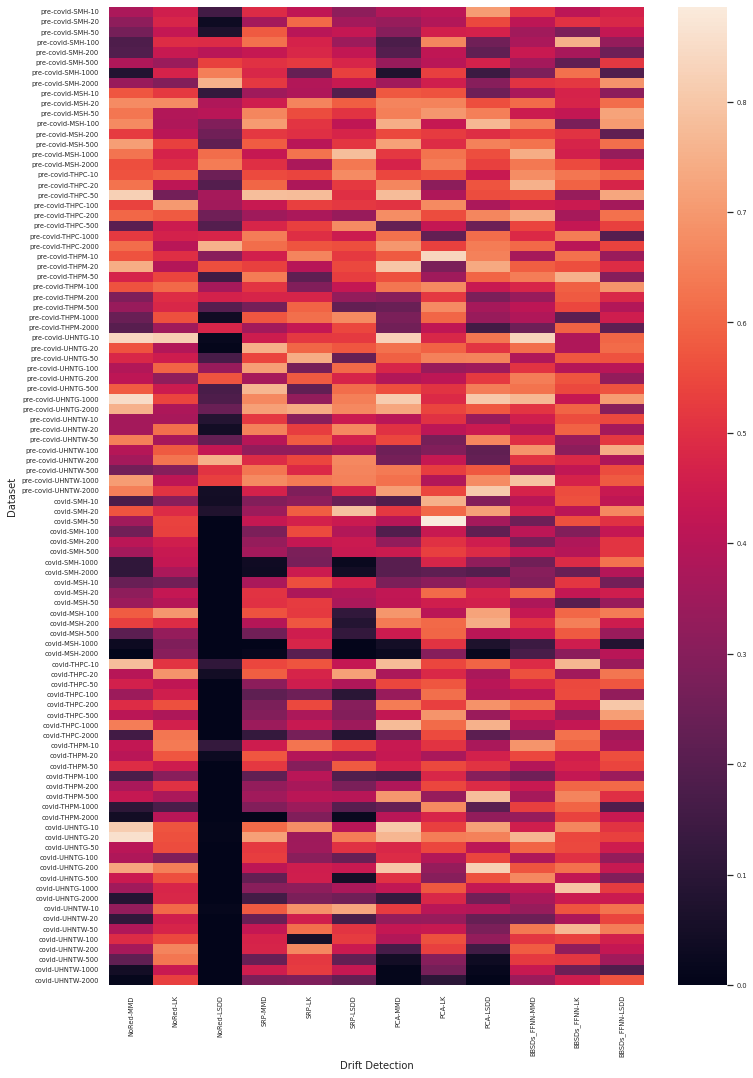

<IPython.core.display.Javascript object>

In [5]:
plt.figure(figsize=(12, 18))
idx = pd.IndexSlice
sns.set(font_scale=0.6)
s = sns.heatmap(means.loc[pd.IndexSlice[["pre-covid", "covid"]], :, :])
s.set_xlabel("Drift Detection", fontsize=10)
s.set_ylabel("Dataset", fontsize=10)
plt.show()

## Seasonal

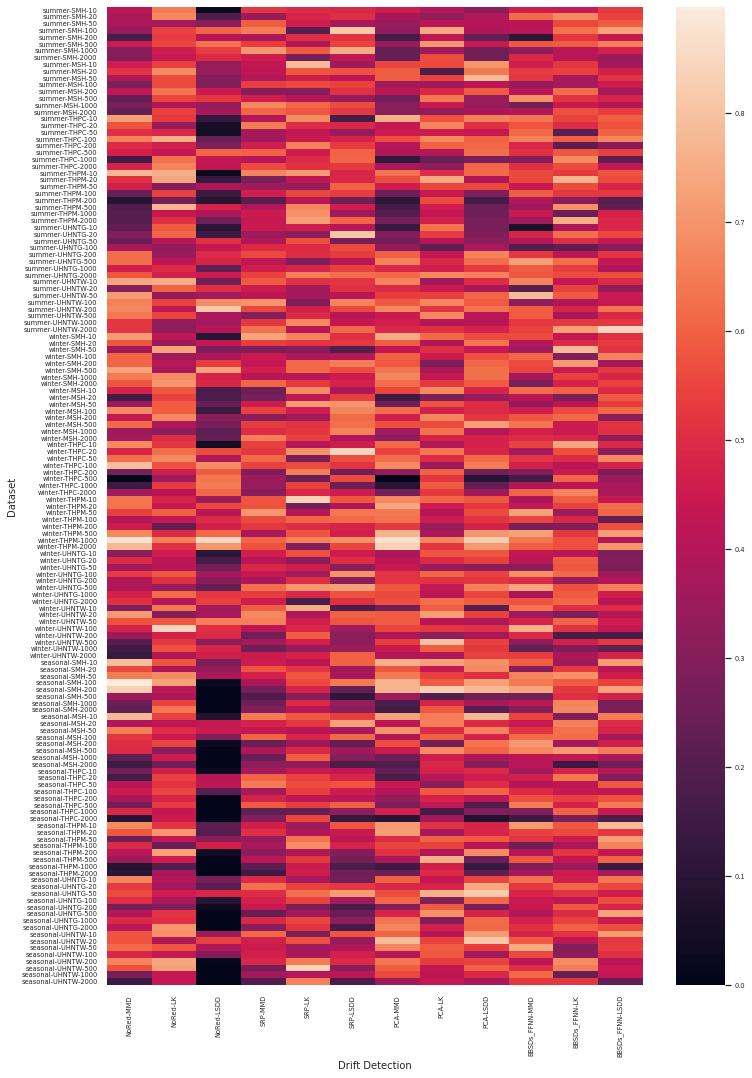

<IPython.core.display.Javascript object>

In [6]:
plt.figure(figsize=(12, 18))
idx = pd.IndexSlice
sns.set(font_scale=0.6)
s = sns.heatmap(means.loc[pd.IndexSlice[["summer", "winter", "seasonal"]], :, :])
s.set_xlabel("Drift Detection", fontsize=10)
s.set_ylabel("Dataset", fontsize=10)
plt.show()